 # Astro Example
Cosmic cleanning of an image composed by 12 Amplifiyers... Warning: gemnini biased! 

In [13]:
# Astro-example

####################
#Cosmic cleanning of an image of 12 detectors
#Uses L.A. Cosmic from P. van Dokkum 
#Requires python version of la_cosmic
#http://www.astro.yale.edu/dokkum/lacosmic/
#it also uses Parallel python PP
##################

#
# La_cosmic must be in the same directory
#
#

import sys, os, string

import astropy
from astropy.io import fits
import numpy as np
import pyfits
import scipy
from scipy import ndimage

# IMPORTING La Cosmic
import cosmics
#time 
import time

# Paralel python
import pp

import matplotlib.pyplot as plt
%matplotlib inline

The image of this example is an IFU science exposure taken with GMOS Hamamatsu CCD: I.e. 12-amp mode readou. Also the image has bias and flat field corrected, but has not beeing mosaiced. So it is a .fits[sci] file with 12 extensions 


In [14]:
imagen_in = "python_club_gemini.fits"

def separa_Amps(imagen_a_corregir):
    #header = pyfits.getheader(imagen_a_corregir)
    # Creating arrays
    imagen = []
    header_amp = []
    Amp = []

    for i in range(1, 13):
        print i
        # Reading each amp. 
        # and creating 12 images, where each one of them corresponds to an Amplifier 
        header_amp.append(pyfits.getheader(imagen_a_corregir, 'sci', i))
        imagen.append(pyfits.getdata(imagen_a_corregir, 'sci', i))
        Amp.append(str(imagen_a_corregir[:-5] + "_Amp_" + str(i) + ".fits"))

    for k in range(0, 12):
        print "writing", Amp[k]
        pyfits.writeto(Amp[k], imagen[k], header_amp[k])

    return

In [15]:
print "Splittings Amps"

start_time1 = time.time()

separa_Amps(imagen_in)

start_time2 = time.time()


Splittings Amps
1
2
3
4
5
6
7
8
9
10
11
12
writing python_club_gemini_Amp_1.fits
writing python_club_gemini_Amp_2.fits
writing python_club_gemini_Amp_3.fits
writing python_club_gemini_Amp_4.fits
writing python_club_gemini_Amp_5.fits
writing python_club_gemini_Amp_6.fits
writing python_club_gemini_Amp_7.fits
writing python_club_gemini_Amp_8.fits
writing python_club_gemini_Amp_9.fits
writing python_club_gemini_Amp_10.fits
writing python_club_gemini_Amp_11.fits
writing python_club_gemini_Amp_12.fits


In [16]:
image_data=pyfits.getdata("python_club_gemini_Amp_7.fits")
print type(image_data)
print image_data.shape

<type 'numpy.ndarray'>
(4176, 512)


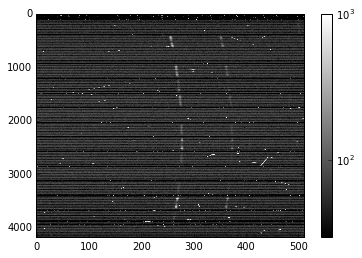

In [17]:
from matplotlib.colors import LogNorm

plt.imshow(image_data,cmap="gray",aspect='auto',norm=LogNorm(vmin=30.08,vmax=1000.1,clip=True))
plt.colorbar()


limpia_cosmicos  calls la_cosmic from P. van Dokkum 

In [18]:
def limpia_cosmicos(imagen_a_corregir, N_Amp):
    # imagen_a_corregir=imagen_in
    #la cosmic routine
    import cosmics

    array, header = cosmics.fromfits(str(imagen_a_corregir[:-5] + "_Amp_" + str(N_Amp) + ".fits"))
    gain_h = header["GAIN"]  # READING GAIN AND NOISE FROM HEADERS
    rnoise = header["RDNOISE"]
    print "READING GAIN AND NOISE ", gain_h, rnoise, str(imagen_a_corregir[:-5] + "_Amp_" + str(N_Amp) + ".fits")

    #Edit this for SCI or STD or Images
    c = cosmics.cosmicsimage(array, gain=gain_h, readnoise=rnoise, sigclip=3, sigfrac=1, objlim=2.0)

    # There are other options, check the manual  la_cosmnic 

    # Run the full artillery 7 iterations is enough:
    c.run(maxiter=7)

    # Write the cleaned image into a new FITS file, conserving the original header :
    cleaned = str(imagen_a_corregir[:-5] + "_CC2_" + str(N_Amp) + ".fits")
    cosmics.tofits(cleaned, c.cleanarray, header)

In [19]:
start_time1 = time.time()
start_time2 = time.time()

#print "iterations for cosmic rejection..."


ppservers = ()

ncpus = 4
# Creates jobserver with ncpus workers
job_server = pp.Server(ncpus, ppservers=ppservers)

print "Starting pp with", job_server.get_ncpus(), "workers aka CPUs"


#Fuerza Bruta....
Amplific= (1,2,3,4,5,6,7,8,9,10,11,12)
jobs=[(input,job_server.submit(limpia_cosmicos,(imagen_in,input,))) for input in Amplific]
for input, job in jobs:
    print "executing job N", input, "is", job()
job_server.print_stats()


print "Total  time elapsed: ", time.time() - start_time2, "s"

Starting pp with 4 workers aka CPUs
executing job N 1 is FITS import shape : (512, 4176)
FITS file BITPIX : -32
Internal array type : float32
READING GAIN AND NOISE  1.0 4.03 python_club_gemini_Amp_1.fits
Detecting saturated stars ...
Building mask of saturated stars ...
We have 0 saturated stars.
Mask of saturated stars done
Starting 7 L.A.Cosmic iterations ...
Iteration 1
cosmics.py:447: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.satstars != None:
cosmics.py:500: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.satstars != None:
17288 cosmic pixels (17288 new)
cosmics.py:235: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.satstars != None:
Iteration 2
1948 cosmic pixels (1936 new)
Iteration 3
360 cosmic pixels (352 new)
Iteration 4
71 cosmic pixels (63 new)
Iteration 5
16 cosmic pixels (8 new)
Itera

In [20]:
image_data=pyfits.getdata("python_club_gemini_CC2_7.fits")
print type(image_data)
print image_data.shape

<type 'numpy.ndarray'>
(4176, 512)


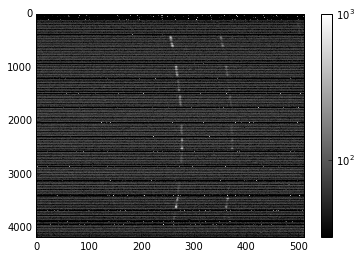

In [32]:
from matplotlib.colors import LogNorm
image_data1=pyfits.getdata("python_club_gemini_CC2_7.fits")

plt.imshow(image_data1,cmap="gray",aspect='auto',norm=LogNorm(vmin=30.08,vmax=1000.1,clip=True))
#plt.imshow(image_data,cmap="gray",norm=LogNorm(vmin=0.1,vmax=0))
plt.colorbar()

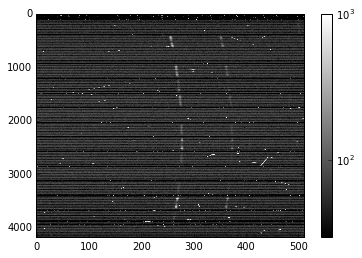

In [31]:
image_data2=pyfits.getdata("python_club_gemini_Amp_7.fits")
plt.imshow(image_data2,cmap="gray",aspect='auto',norm=LogNorm(vmin=30.08,vmax=1000.1,clip=True))
plt.colorbar()

In [34]:
#Updating image...

imagen_in = "python_club_gemini.fits"
imagen_end = "python_club_gemini.fits"

imagen_a_corregir=imagen_in
FILE_FIN=imagen_end+"_CC2.fits"    #imagen final
FILE_TEMP=imagen_end+"_tmp.fits"    #imagen Temporal donde se hacen los cambios
imagen_header_original=imagen_in   # Imagen Original con todos los headers,

import shutil

#   making a copy of the priginal file to a temporal one.
shutil.copyfile(imagen_header_original,FILE_TEMP)
imagen_header2=FILE_TEMP

for i in range (1,13):

    imagen_Corre=str(imagen_a_corregir[:-5]+"_CC2_"+str(i)+".fits")  # Output of correction "CC2", NAME_CC2.fits
    imagen_no_header=pyfits.getdata(imagen_Corre,header=False)
    header=pyfits.getheader(FILE_TEMP)
    header2=pyfits.getheader(FILE_TEMP,i)
    pyfits.update(imagen_header2,imagen_no_header,ext=i) #copia la imagen en si a la extension correspondiente
    pyfits.update(imagen_header2,imagen_no_header,header2,i) #copia el header original a la extension correspondiente


import shutil
shutil.copyfile(FILE_TEMP,FILE_FIN)##

##Final Sanity check

#pyfits.info(FILE_FIN)
#print "Deleting files"

#print "Deleting _CC_ files and _Amp_ files"

#for m in range (1,13):
#    print " rm "+imagen_a_corregir[:-5]+"_CC2_"+str(m)+".fits"
#    os.remove(imagen_a_corregir[:-5]+"_CC2_"+str(m)+".fits")
#    print " rm "+imagen_a_corregir[:-5]+"_Amp_"+str(m)+".fits"
#    os.remove(imagen_a_corregir[:-5]+"_Amp_"+str(m)+".fits")


print "Cosmic cleaning done"

print "\n Marcelo D. Mora, 07.09.2016 mmora@astro.puc.cl v.2.0 \n"

Cosmic cleaning done

 Marcelo D. Mora, 07.09.2016 mmora@astro.puc.cl v.2.0 

